# Adat Elemzés és Validáció

Ez a notebook a CourtRankRL projekt adatainak elemzését és validálását végzi.
A következő lépéseket tartalmazza:
1. **Szöveghossz eloszlás**: Nyers szövegek hosszának vizsgálata.
2. **Kinyert metaadatok ellenőrzése**: A preprocess folyamat során kinyert metaadatok minőségi és mennyiségi ellenőrzése.
3. **Embedding validálása**: PCA vizualizáció és domain szerinti színezés.
4. **Metaadat vizsgálatok**: Leggyakoribb bíróságok, évszám eloszlás, jogterületek vizualizációja.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import os
import glob
import re
from docx import Document
from tqdm import tqdm

# Beállítások
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Útvonalak
DATA_DIR = '../data/processed'
RAW_DATA_DIR = '../data/raw'

PROCESSED_DOCS_PATH = os.path.join(DATA_DIR, 'processed_docs.jsonl')
CHUNKS_PATH = os.path.join(DATA_DIR, 'chunks.jsonl')
EMBEDDINGS_PATH = os.path.join(DATA_DIR, 'embeddings.npy')
EMBEDDING_IDS_PATH = os.path.join(DATA_DIR, 'embedding_chunk_ids.json')

In [2]:
# 1. Nyers adatok betöltése (.docx fájlok) - CSAK SZÖVEGHOSSZ
print("Nyers .docx fájlok keresése és betöltése (Szöveghossz elemzéshez)...")

raw_docs_data = []

# Rekurzív keresés a raw mappában
docx_files = glob.glob(os.path.join(RAW_DATA_DIR, '**/*.docx'), recursive=True)
if not docx_files:
    docx_files = glob.glob(os.path.join(RAW_DATA_DIR, '**/*.DOCX'), recursive=True)

print(f"Találat: {len(docx_files)} db .docx fájl.")

# Minta a gyorsabb futtatáshoz (opcionális, állítsd None-ra a teljes elemzéshez)
LIMIT = None 
files_to_process = docx_files[:LIMIT] if LIMIT else docx_files

print("Fájlok feldolgozása (ez eltarthat egy ideig)...")
for file_path in tqdm(files_to_process):
    try:
        # Csak a szöveghosszt vizsgáljuk a nyers fájlokon
        doc = Document(file_path)
        full_text = "\n".join([para.text for para in doc.paragraphs])
        text_length = len(full_text)
        
        raw_docs_data.append({
            'path': file_path,
            'text_length': text_length
        })
    except Exception as e:
        pass

raw_docs_df = pd.DataFrame(raw_docs_data)
print(f"\nSikeresen feldolgozva: {len(raw_docs_df)} nyers dokumentum.")

# 2. Feldolgozott adatok betöltése (Metaadatok és Embeddingek)
print("\nFeldolgozott adatok (Chunks, Embeddings) betöltése...")

if os.path.exists(EMBEDDINGS_PATH):
    embeddings = np.load(EMBEDDINGS_PATH)
    print(f"Embeddings betöltve: {embeddings.shape}")
else:
    print(f"HIBA: {EMBEDDINGS_PATH} nem található.")
    embeddings = None

# Chunks metadata betöltése
chunk_data = []
if os.path.exists(CHUNKS_PATH):
    print("Chunks metadata beolvasása (Metaadat elemzéshez)...")
    with open(CHUNKS_PATH, 'r') as f:
        for i, line in enumerate(f):
            try:
                chunk = json.loads(line)
                chunk_data.append({
                    'chunk_id': chunk.get('chunk_id'),
                    'doc_id': chunk.get('doc_id'),
                    'court': chunk.get('court'),
                    'domain': chunk.get('domain'),
                    'year': chunk.get('year'),
                    'chunk_length': len(chunk.get('text', ''))
                })
            except json.JSONDecodeError:
                pass
    chunks_df = pd.DataFrame(chunk_data)
    print(f"Chunks metadata betöltve: {len(chunks_df)} chunk.")
    
    # Dokumentum szintű metaadatok előállítása (egyedi doc_id alapján)
    if not chunks_df.empty and 'doc_id' in chunks_df.columns:
        docs_metadata_df = chunks_df.drop_duplicates(subset='doc_id').copy()
        print(f"Egyedi dokumentumok száma a feldolgozott adatokban: {len(docs_metadata_df)}")
    else:
        docs_metadata_df = pd.DataFrame()
else:
    print(f"HIBA: {CHUNKS_PATH} nem található.")
    chunks_df = pd.DataFrame()
    docs_metadata_df = pd.DataFrame()

Nyers .docx fájlok keresése és betöltése (Szöveghossz elemzéshez)...
Találat: 45105 db .docx fájl.
Fájlok feldolgozása (ez eltarthat egy ideig)...
Találat: 45105 db .docx fájl.
Fájlok feldolgozása (ez eltarthat egy ideig)...


100%|██████████| 45105/45105 [07:01<00:00, 107.09it/s]




Sikeresen feldolgozva: 45105 nyers dokumentum.

Feldolgozott adatok (Chunks, Embeddings) betöltése...
Embeddings betöltve: (2964527, 768)
Chunks metadata beolvasása (Metaadat elemzéshez)...
Embeddings betöltve: (2964527, 768)
Chunks metadata beolvasása (Metaadat elemzéshez)...
Chunks metadata betöltve: 2964524 chunk.
Egyedi dokumentumok száma a feldolgozott adatokban: 43959
Chunks metadata betöltve: 2964524 chunk.
Egyedi dokumentumok száma a feldolgozott adatokban: 43959


## 1. Szöveghossz eloszlás (Nyers dokumentumok)
A nyers `.docx` fájlok teljes szöveghosszának vizsgálata karakterben. Ez a feldolgozás előtti állapotot tükrözi.

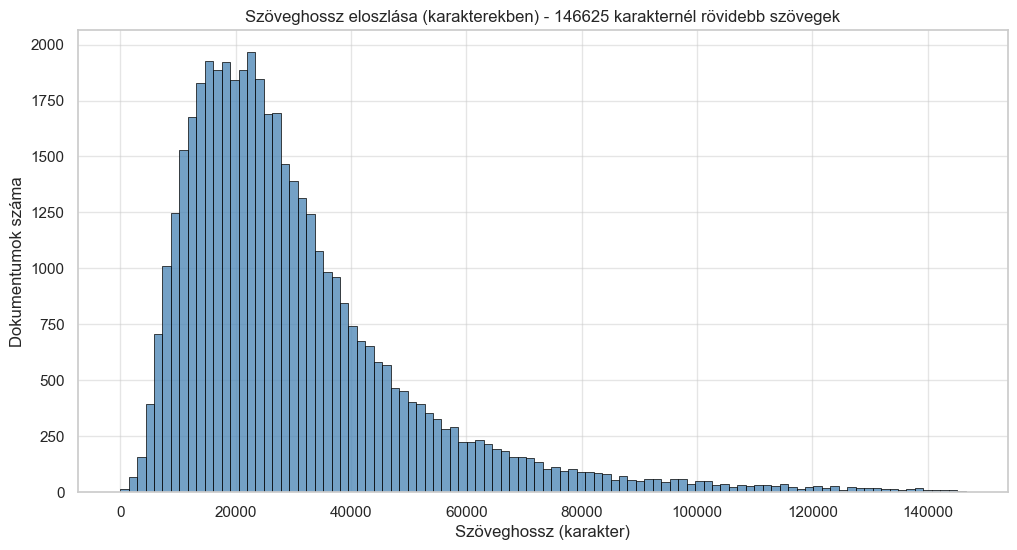

Átlagos dokumentumhossz: 32946.92
Medián dokumentumhossz: 25481.00
Minimális dokumentumhossz: 0
Maximális dokumentumhossz: 1745997


In [7]:
if not raw_docs_df.empty:
    # 99%-os percentilis kiszámítása a kiugró értékek szűréséhez
    limit = raw_docs_df['text_length'].quantile(0.99)
    
    # Szűrt adatok
    filtered_df = raw_docs_df[raw_docs_df['text_length'] < limit]
    
    plt.figure(figsize=(12, 6))
    sns.histplot(filtered_df['text_length'], bins=100, kde=False, color='steelblue', edgecolor='black', linewidth=0.5)
    plt.title(f'Szöveghossz eloszlása (karakterekben) - {int(limit)} karakternél rövidebb szövegek')
    plt.xlabel('Szöveghossz (karakter)')
    plt.ylabel('Dokumentumok száma')
    plt.grid(True, alpha=0.5)
    plt.show()
    
    print(f"Átlagos dokumentumhossz: {raw_docs_df['text_length'].mean():.2f}")
    print(f"Medián dokumentumhossz: {raw_docs_df['text_length'].median():.2f}")
    print(f"Minimális dokumentumhossz: {raw_docs_df['text_length'].min()}")
    print(f"Maximális dokumentumhossz: {raw_docs_df['text_length'].max()}")
else:
    print("Nincs elérhető nyers dokumentum adat.")

## 2. Kinyert metaadatok ellenőrzése (Feldolgozott adatok alapján)
A preprocess folyamat során kinyert metaadatok (bíróság, jogterület, évszám) minőségi és mennyiségi ellenőrzése a `chunks.jsonl` alapján.

In [4]:
if not chunks_df.empty:
    print("Hiányzó értékek a metaadatokban (Chunk szinten):")
    missing_values = chunks_df[['court', 'domain', 'year']].isnull().sum()
    print(missing_values)
    
    print("\nEgyedi értékek száma (Dokumentum szinten):")
    if not docs_metadata_df.empty:
        print(f"Bíróságok: {docs_metadata_df['court'].nunique()}")
        print(f"Jogterületek: {docs_metadata_df['domain'].nunique()}")
        print(f"Évek: {docs_metadata_df['year'].nunique()}")
        
        # Ellenőrzés üres stringekre is
        print("\nÜres stringek száma (Dokumentum szinten):")
        print(f"Court üres: {(docs_metadata_df['court'] == '').sum()}")
        print(f"Domain üres: {(docs_metadata_df['domain'] == '').sum()}")
        print(f"Year üres: {(docs_metadata_df['year'] == '').sum()}")
    else:
        print("Nincs elérhető dokumentum szintű adat.")
else:
    print("Nincs elérhető chunk adat.")

Hiányzó értékek a metaadatokban (Chunk szinten):
court     0
domain    0
year      0
dtype: int64

Egyedi értékek száma (Dokumentum szinten):
Bíróságok: 593
Jogterületek: 6
Évek: 28

Üres stringek száma (Dokumentum szinten):
Court üres: 0
Domain üres: 0
Year üres: 4331
court     0
domain    0
year      0
dtype: int64

Egyedi értékek száma (Dokumentum szinten):
Bíróságok: 593
Jogterületek: 6
Évek: 28

Üres stringek száma (Dokumentum szinten):
Court üres: 0
Domain üres: 0
Year üres: 4331


## 3. Embedding validálása
Az embeddingek vizualizációja PCA (Principal Component Analysis) segítségével, 2 dimenzióra redukálva.
A pontok színezése a jogterület (domain) alapján történik, hogy lássuk, elkülönülnek-e a különböző jogterületek.

FIGYELEM: Az embeddingek száma (2964527) nem egyezik a chunkok számával (2964524).
Megkísérlem az összefésülést az embedding_chunk_ids.json segítségével...
Közös elemek száma: 3298528
Közös elemek száma: 3298528
Dokumentum szintű embeddingek számítása (átlagolás)...
Dokumentum szintű embeddingek számítása (átlagolás)...
Összesen 43959 egyedi dokumentum azonosítva.
Összesen 43959 egyedi dokumentum azonosítva.
PCA számítása dokumentum szinten...
Túl sok dokumentum (43959). Véletlenszerű minta vétele (10000 db)...
PCA számítása dokumentum szinten...
Túl sok dokumentum (43959). Véletlenszerű minta vétele (10000 db)...


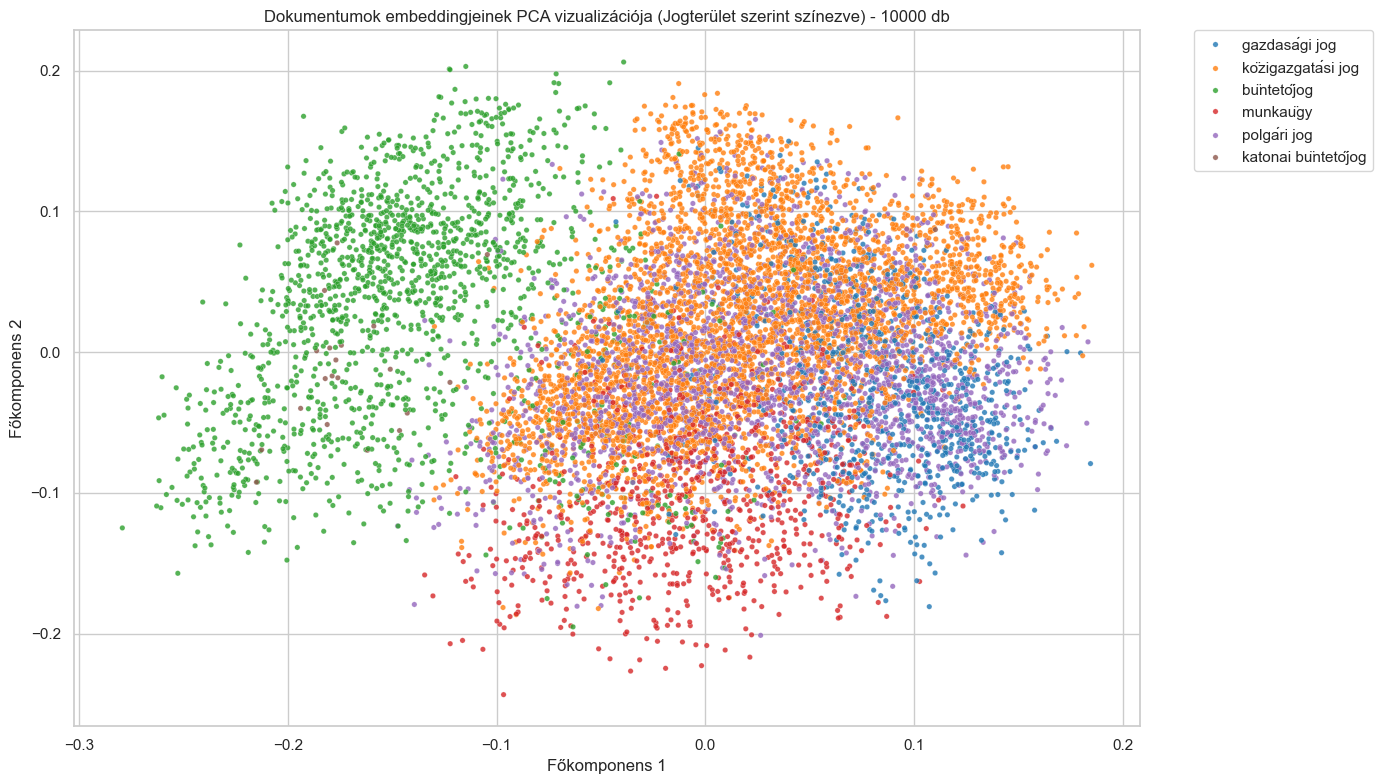

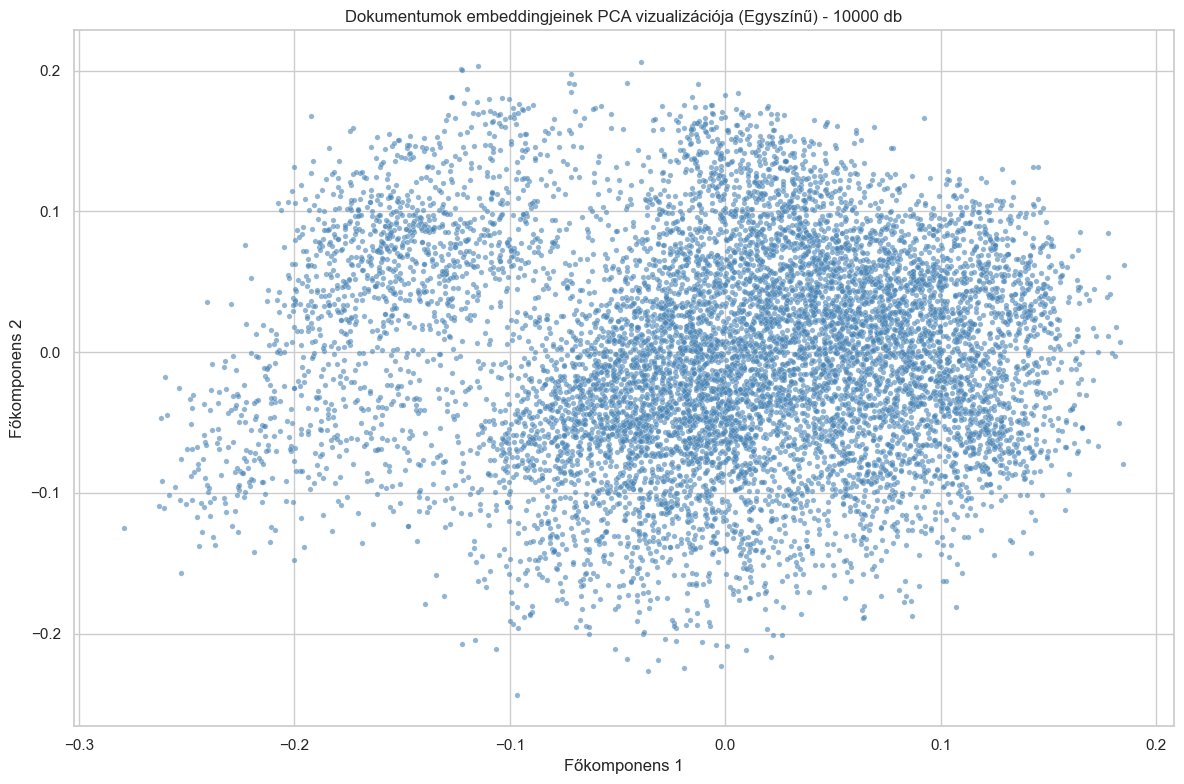

Magyarázott variancia arány: [0.10886653 0.07815171]


In [10]:
if embeddings is not None and not chunks_df.empty:
    # Ellenőrizzük, hogy az embeddingek száma egyezik-e a chunkok számával
    if len(embeddings) == len(chunks_df):
        print("Az embeddingek és chunkok száma egyezik.")
        embeddings_to_process = embeddings
        process_df = chunks_df.copy()
    else:
        print(f"FIGYELEM: Az embeddingek száma ({len(embeddings)}) nem egyezik a chunkok számával ({len(chunks_df)}).")
        print("Megkísérlem az összefésülést az embedding_chunk_ids.json segítségével...")
        
        if os.path.exists(EMBEDDING_IDS_PATH):
            with open(EMBEDDING_IDS_PATH, 'r') as f:
                embedding_ids = json.load(f)
            
            if len(embedding_ids) != len(embeddings):
                print(f"KRITIKUS HIBA: Az embedding ID-k száma ({len(embedding_ids)}) nem egyezik az embeddingek számával ({len(embeddings)}).")
                embeddings_to_process = None
            else:
                # DataFrame az embedding ID-khoz
                emb_df = pd.DataFrame({'chunk_id': embedding_ids, 'emb_index': range(len(embedding_ids))})
                
                # Összefésülés a chunks_df-fel
                merged_df = pd.merge(chunks_df, emb_df, on='chunk_id', how='inner')
                
                print(f"Közös elemek száma: {len(merged_df)}")
                
                if not merged_df.empty:
                    # Kiválasztjuk a megfelelő embeddingeket az indexek alapján
                    indices = merged_df['emb_index'].values
                    embeddings_to_process = embeddings[indices]
                    process_df = merged_df
                else:
                    print("Nincs közös elem a chunkok és az embeddingek között.")
                    embeddings_to_process = None
        else:
            print(f"HIBA: {EMBEDDING_IDS_PATH} nem található, nem lehet összefésülni.")
            embeddings_to_process = None

    if embeddings_to_process is not None:
        print("Dokumentum szintű embeddingek számítása (átlagolás)...")
        
        if 'doc_id' not in process_df.columns:
             print("HIBA: Nincs 'doc_id' oszlop az adatokban, nem lehet dokumentum szinten vizualizálni.")
        else:
            # Dokumentumok azonosítása és indexelése
            unique_docs = process_df['doc_id'].unique()
            doc_to_idx = {doc_id: i for i, doc_id in enumerate(unique_docs)}
            num_docs = len(unique_docs)
            embedding_dim = embeddings_to_process.shape[1]
            
            print(f"Összesen {num_docs} egyedi dokumentum azonosítva.")
            
            # Akkumulátorok inicializálása
            doc_embeddings_sum = np.zeros((num_docs, embedding_dim), dtype=np.float32)
            doc_counts = np.zeros(num_docs, dtype=np.float32)
            
            # Mappelés int indexekre
            doc_indices = process_df['doc_id'].map(doc_to_idx).values
            
            # Embeddingek aggregálása
            np.add.at(doc_embeddings_sum, doc_indices, embeddings_to_process)
            np.add.at(doc_counts, doc_indices, 1)
            
            # Átlagolás
            doc_embeddings = doc_embeddings_sum / doc_counts[:, None]
            
            # Metaadatok (domain) kinyerése dokumentum szinten
            doc_metadata = process_df.drop_duplicates('doc_id')[['doc_id', 'domain']].set_index('doc_id')
            doc_domains = [doc_metadata.loc[doc_id, 'domain'] for doc_id in unique_docs]
            
            doc_plot_df = pd.DataFrame({
                'doc_id': unique_docs,
                'domain': doc_domains
            })
            
            print("PCA számítása dokumentum szinten...")
            
            # Mintavételezés ha túl sok a dokumentum
            SAMPLE_SIZE = 10000
            if len(doc_embeddings) > SAMPLE_SIZE:
                print(f"Túl sok dokumentum ({len(doc_embeddings)}). Véletlenszerű minta vétele ({SAMPLE_SIZE} db)...")
                indices = np.random.choice(len(doc_embeddings), SAMPLE_SIZE, replace=False)
                embeddings_subset = doc_embeddings[indices]
                plot_df_subset = doc_plot_df.iloc[indices].copy()
            else:
                embeddings_subset = doc_embeddings
                plot_df_subset = doc_plot_df.copy()

            pca = PCA(n_components=2)
            embeddings_2d = pca.fit_transform(embeddings_subset)
            
            plot_df_subset['pca_x'] = embeddings_2d[:, 0]
            plot_df_subset['pca_y'] = embeddings_2d[:, 1]
            
            # 1. Vizualizáció: Jogterület szerint színezve
            plt.figure(figsize=(14, 8))
            sns.scatterplot(
                data=plot_df_subset,
                x='pca_x',
                y='pca_y',
                hue='domain',
                alpha=0.8,
                palette='tab10',
                s=15,
                edgecolor='white',
                linewidth=0.2
            )
            plt.title(f'Dokumentumok embeddingjeinek PCA vizualizációja (Jogterület szerint színezve) - {len(plot_df_subset)} db')
            plt.xlabel('Főkomponens 1')
            plt.ylabel('Főkomponens 2')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            
            # 2. Vizualizáció: Egyszínű (Sima PCA)
            plt.figure(figsize=(12, 8))
            sns.scatterplot(
                data=plot_df_subset,
                x='pca_x',
                y='pca_y',
                alpha=0.6,
                color='steelblue', # Egységes szín
                s=15,
                edgecolor='white',
                linewidth=0.2
            )
            plt.title(f'Dokumentumok embeddingjeinek PCA vizualizációja (Egyszínű) - {len(plot_df_subset)} db')
            plt.xlabel('Főkomponens 1')
            plt.ylabel('Főkomponens 2')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            
            print(f"Magyarázott variancia arány: {pca.explained_variance_ratio_}")
else:
    print("Nincs elegendő adat a vizualizációhoz.")

## 4. Metaadat vizsgálatok (Feldolgozott adatok alapján)
A leggyakoribb bíróságok, az évszámok eloszlása és a jogterületek arányának vizuális megjelenítése a feldolgozott dokumentumok alapján.

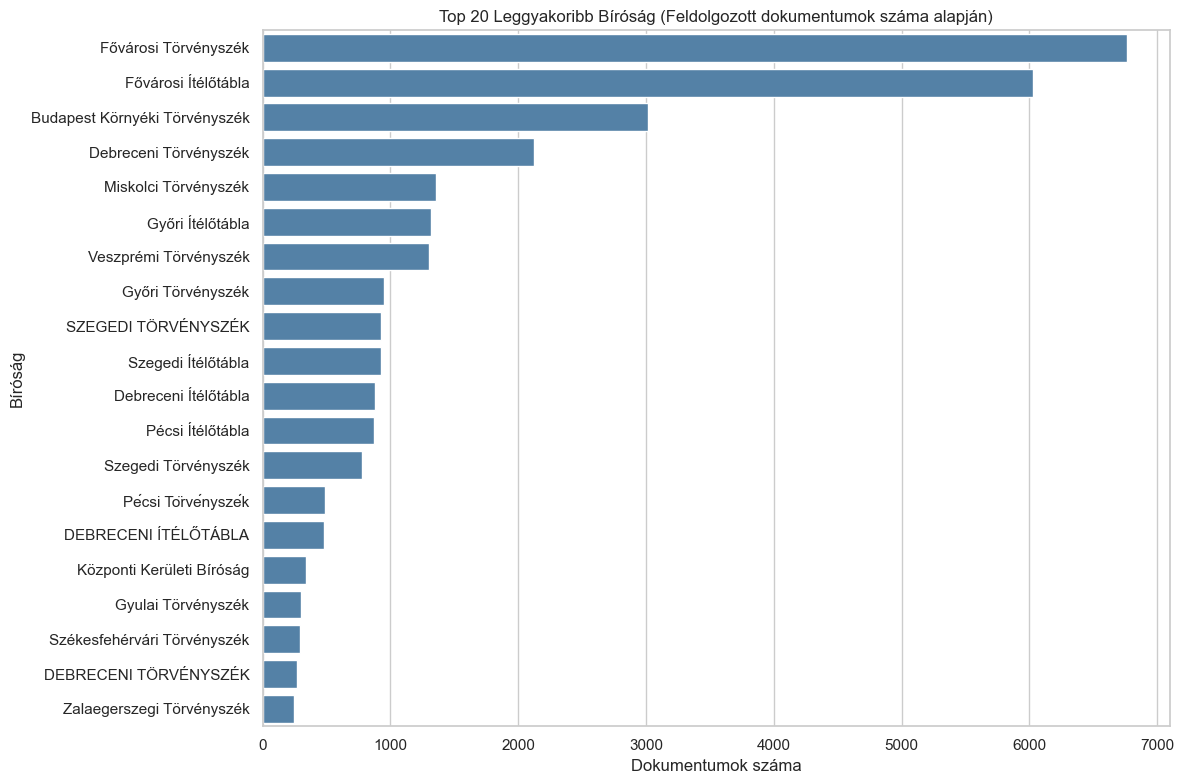

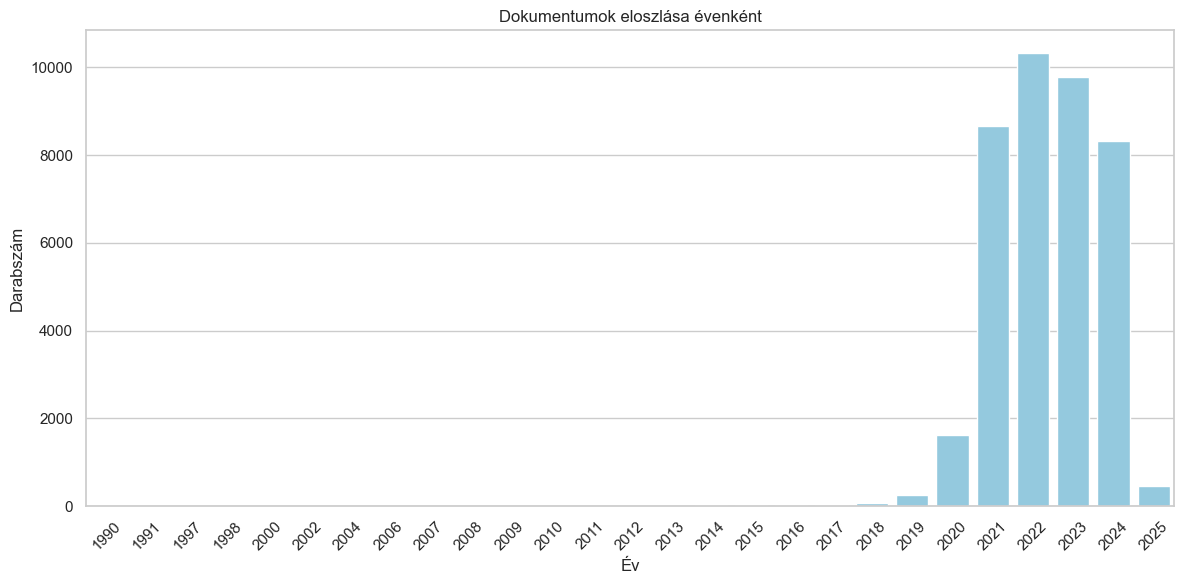

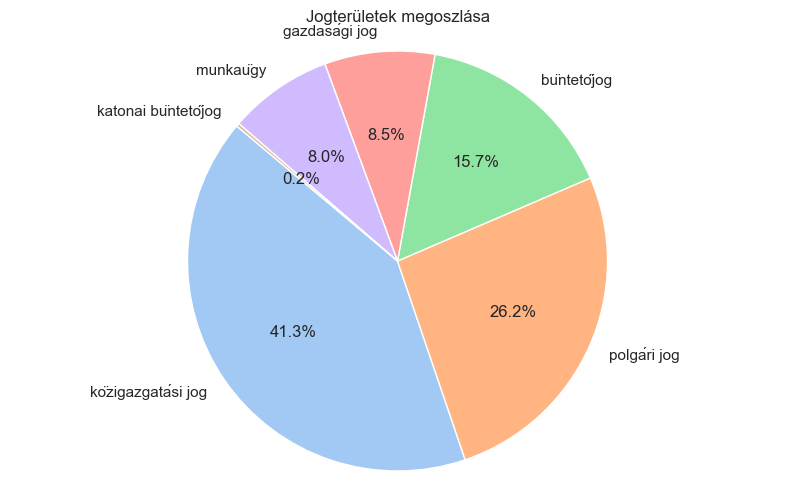

In [11]:
if not docs_metadata_df.empty:
    # 1. Leggyakoribb bíróságok
    plt.figure(figsize=(12, 8))
    # Szűrés: "mint felülvizsgálati bíróság" és "mint másodfokú bíróság" eltávolítása
    filtered_courts_df = docs_metadata_df[~docs_metadata_df['court'].isin(['mint felülvizsgálati bíróság', 'mint másodfokú bíróság'])]
    
    top_courts = filtered_courts_df['court'].value_counts().head(20)
    
    # Egyszínű (pl. steelblue) oszlopdiagram
    sns.barplot(y=top_courts.index, x=top_courts.values, color='steelblue')
    
    plt.title('Top 20 Leggyakoribb Bíróság (Feldolgozott dokumentumok száma alapján)')
    plt.xlabel('Dokumentumok száma')
    plt.ylabel('Bíróság')
    plt.tight_layout()
    plt.show()
    
    # 2. Évszám eloszlás
    plt.figure(figsize=(12, 6))
    # Szűrjük ki a nem valid évszámokat
    valid_years = docs_metadata_df[docs_metadata_df['year'].astype(str).str.match(r'^\d{4}$')]
    year_counts = valid_years['year'].value_counts().sort_index()
    
    sns.barplot(x=year_counts.index, y=year_counts.values, color='skyblue')
    plt.title('Dokumentumok eloszlása évenként')
    plt.xlabel('Év')
    plt.ylabel('Darabszám')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. Jogterületek eloszlása
    plt.figure(figsize=(10, 6))
    domain_counts = docs_metadata_df['domain'].value_counts()
    plt.pie(domain_counts.values, labels=domain_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title('Jogterületek megoszlása')
    plt.axis('equal')
    plt.show()
else:
    print("Nincs elérhető dokumentum adat.")